In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()

(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

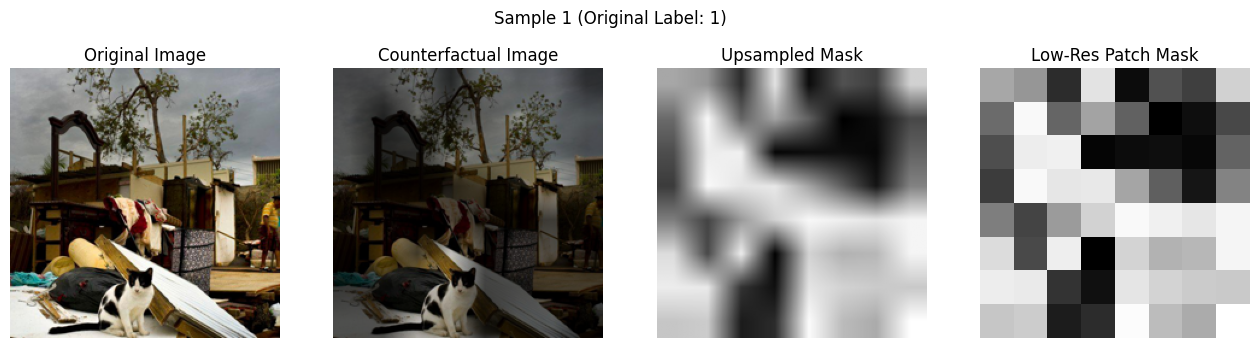

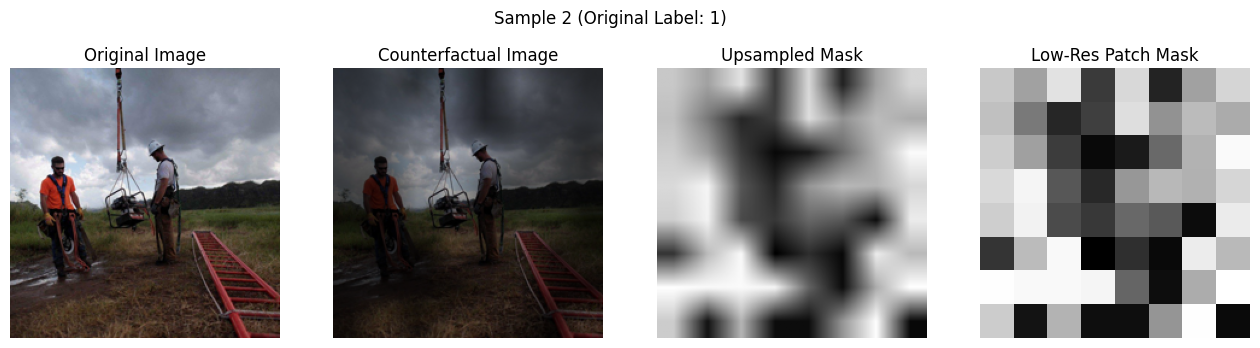

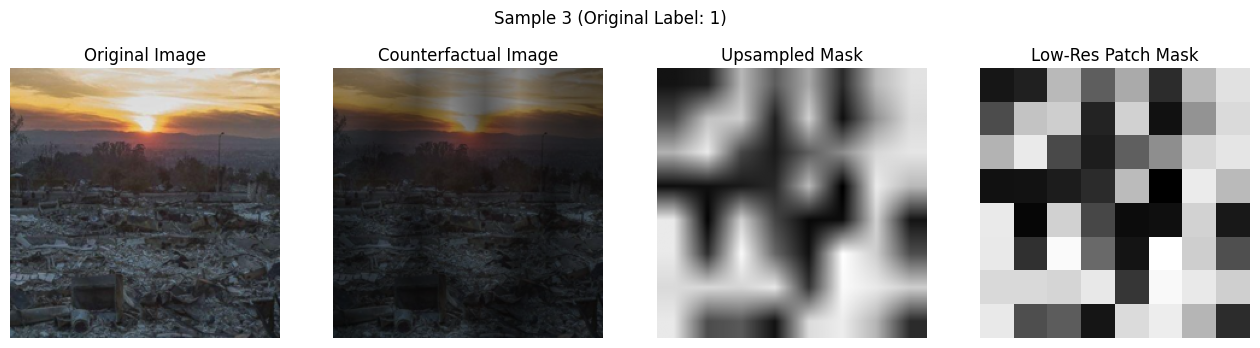

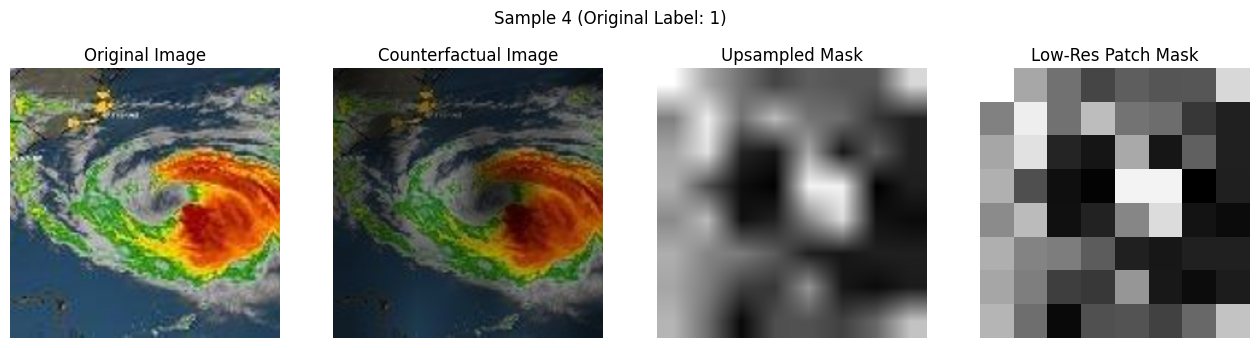

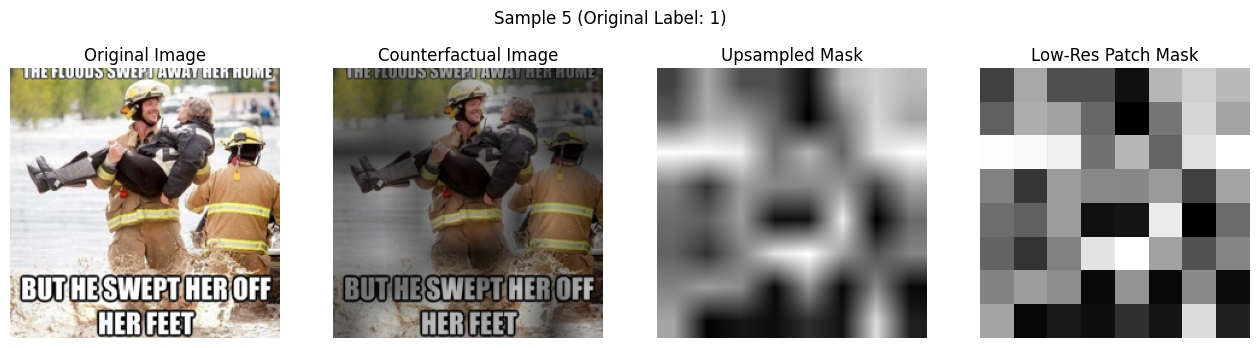

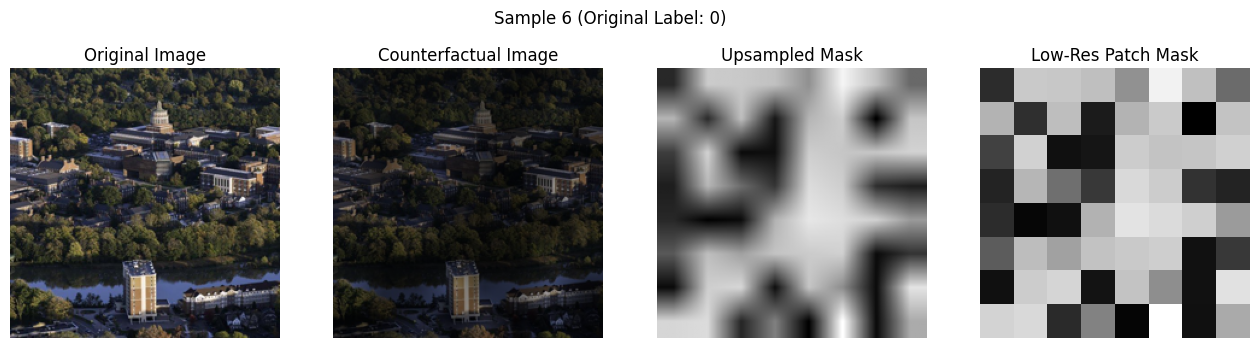

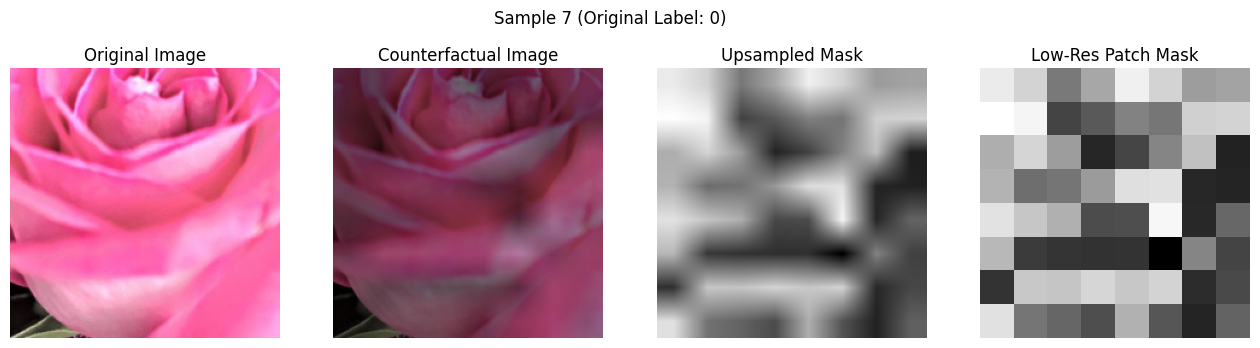

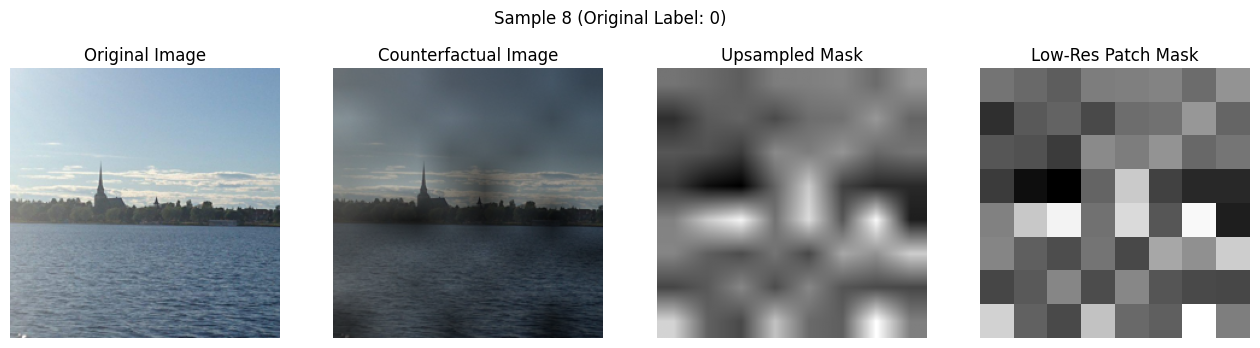

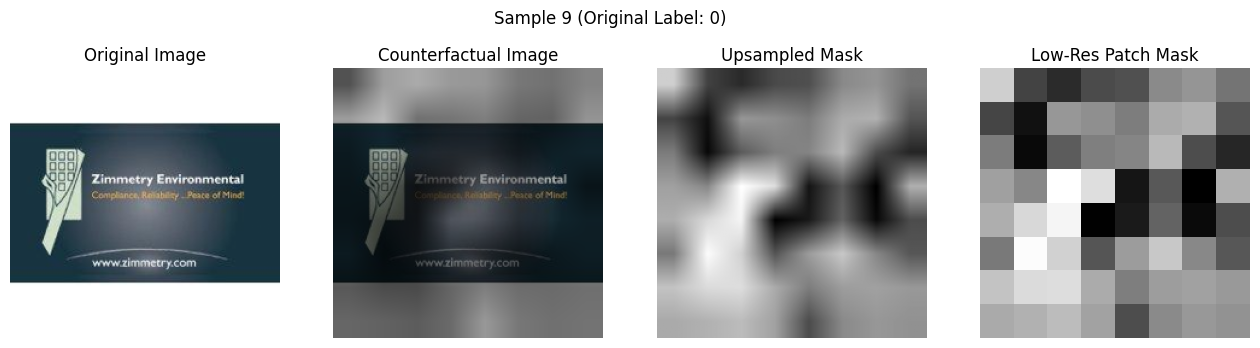

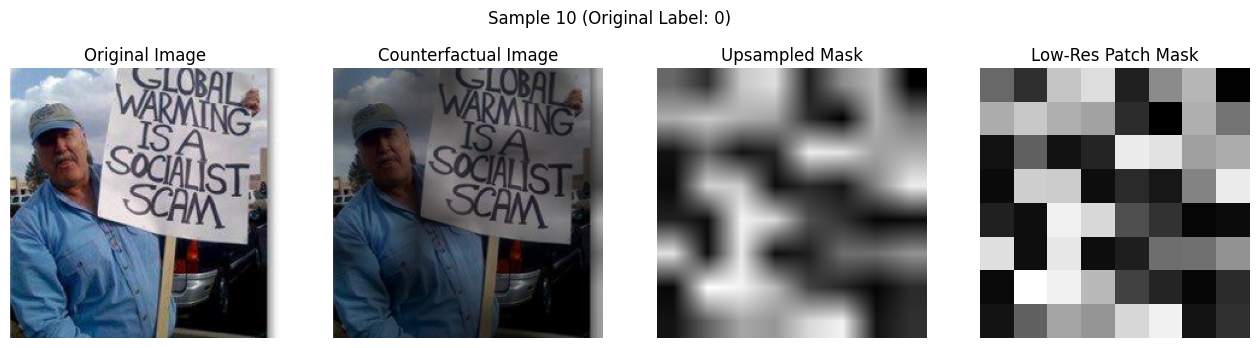

Displayed original, counterfactual images, and the patch-based masks for each sample.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# ----------------------------
# Setup and Model Loading
# ----------------------------
model_save_path = r"D:\BTP_2\CrisisMMD_v2.0\model\Model_CLIP\model.pt"
image_dir = ""  # Replace with the actual path to your image directory

# Load the CLIP processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Define the multimodal classifier class
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model):
        super(MultimodalClassifier, self).__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(clip_model.config.projection_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # One logit for binary classification
        )

    def forward(self, inputs):
        text_embeddings = self.clip_model.get_text_features(inputs['input_ids'].squeeze(1))
        image_embeddings = self.clip_model.get_image_features(inputs['pixel_values'])
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)
        output = self.classifier(combined_embeddings)
        return output

# Load the saved model
model = MultimodalClassifier(clip_model)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# ----------------------------
# Dataset and Sampling
# ----------------------------
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        return inputs, torch.tensor(label)

def load_sample_examples_by_label(dataframe, image_dir, processor, num_samples=5):
    """
    From a dataframe filtered with label_text_image == 'Positive', sample
    num_samples examples for each binary label.
    """
    examples = []
    # Group by the binary label (assumed stored in 'label')
    for label_value, group in dataframe.groupby('label'):
        sampled_group = group.sample(n=min(num_samples, len(group)), random_state=42)
        for _, row in sampled_group.iterrows():
            text = row['tweet_text']
            image_path = image_dir + row['image']
            label = 1 if row['label'] == 'informative' else 0
            image = Image.open(image_path).convert("RGB")
            inputs = processor(
                text=text,
                images=image,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=77
            )
            examples.append((inputs, label))
    return examples

# Load the validation dataframe and filter by 'Positive'
val_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')
val_df_positive = val_df[val_df['label_text_image'] == 'Positive']

# Sample 5 examples for each binary label
sample_examples = load_sample_examples_by_label(val_df_positive, image_dir, processor, num_samples=5)

# ----------------------------
# Counterfactual Generation (Patch-based Black Pixel Addition)
# ----------------------------
def generate_counterfactual_black_patch(model, inputs, original_label, steps=100, lr=0.01, lambda_reg=0.1, grid_size=(8, 8)):
    """
    Generate a counterfactual by optimizing a low-resolution mask (patch grid) that replaces parts of the image with black.
    The mask is upsampled to the image resolution.
    The counterfactual image is computed as:
        cf = original * (1 - mask) + black * mask,
    where mask is optimized so that the classifier's prediction flips.
    """
    model.eval()
    # Get original image pixels from inputs (shape: [1, 3, H, W])
    orig_pixels = inputs["pixel_values"].clone()
    _, C, H, W = orig_pixels.shape

    # Create a mask parameter of shape [1, 1, grid_h, grid_w]
    grid_h, grid_w = grid_size
    mask_param = torch.zeros((1, 1, grid_h, grid_w), requires_grad=True, device=orig_pixels.device)
    
    # Define black in normalized space: for CLIP, black is computed as (0 - mean)/std.
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=orig_pixels.device).view(1,3,1,1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=orig_pixels.device).view(1,3,1,1)
    black_val = (0 - mean) / std  # normalized black pixel values
    
    optimizer = optim.Adam([mask_param], lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    # Target: flip the original label (1->0 or 0->1)
    target_label = torch.tensor([[1.0 - original_label]], dtype=torch.float32, device=orig_pixels.device)
    
    for step in range(steps):
        optimizer.zero_grad()
        # Compute low-res mask via sigmoid (values in [0,1])
        low_res_mask = torch.sigmoid(mask_param)  # shape: [1,1,grid_h, grid_w]
        # Upsample mask to the original image resolution using bilinear interpolation
        mask = F.interpolate(low_res_mask, size=(H, W), mode='bilinear', align_corners=False)
        mask_expanded = mask.repeat(1, 3, 1, 1)
        # Compute counterfactual image: add black patches where mask is high
        cf_pixels = orig_pixels * (1 - mask_expanded) + black_val * mask_expanded
        inputs_cf = copy.deepcopy(inputs)
        inputs_cf["pixel_values"] = cf_pixels
        output = model(inputs_cf)
        loss_pred = loss_fn(output, target_label)
        # Regularization: encourage sparsity (few patches) using L1 norm on mask
        loss_reg = lambda_reg * torch.mean(mask)
        loss = loss_pred + loss_reg
        loss.backward()
        optimizer.step()
    
    # Final mask and counterfactual image
    final_low_res_mask = torch.sigmoid(mask_param).detach()
    final_mask = F.interpolate(final_low_res_mask, size=(H, W), mode='bilinear', align_corners=False)
    mask_expanded = final_mask.repeat(1, 3, 1, 1)
    cf_pixels = orig_pixels * (1 - mask_expanded) + black_val * mask_expanded
    return cf_pixels.detach(), final_mask.detach(), final_low_res_mask.detach()

# ----------------------------
# Visualization Helpers
# ----------------------------
def denormalize(image_tensor):
    """
    Denormalize the image tensor using the CLIP default normalization parameters.
    """
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1)
    image_tensor = image_tensor * std + mean
    return torch.clamp(image_tensor, 0, 1)

def tensor_to_numpy(image_tensor):
    """
    Convert a tensor image (1,3,H,W) to a numpy array (H,W,3).
    """
    return image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# ----------------------------
# Generate and Display Counterfactuals with Patches
# ----------------------------
for i, (inputs, label) in enumerate(sample_examples):
    # Generate counterfactual using patch-based black pixel addition
    cf_pixels, full_mask, low_res_mask = generate_counterfactual_black_patch(model, inputs, label,
                                                                             steps=100, lr=0.01, lambda_reg=0.1,
                                                                             grid_size=(8, 8))
    
    # Denormalize images for visualization
    orig_img = denormalize(inputs["pixel_values"]).squeeze(0).permute(1, 2, 0).cpu().numpy()
    cf_img = denormalize(cf_pixels).squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    # Display the full-resolution mask and the low-res patch grid mask
    mask_img = full_mask.squeeze(0).squeeze(0).cpu().numpy()
    low_res_mask_img = low_res_mask.squeeze(0).squeeze(0).cpu().numpy()
    
    # Plot the original image, counterfactual image, full mask, and low-res patch mask
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(cf_img)
    plt.title("Counterfactual Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(mask_img, cmap='gray')
    plt.title("Upsampled Mask")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(low_res_mask_img, cmap='gray')
    plt.title("Low-Res Patch Mask")
    plt.axis("off")
    
    plt.suptitle(f"Sample {i+1} (Original Label: {label})")
    plt.show()

print("Displayed original, counterfactual images, and the patch-based masks for each sample.")
